## Imports and dataset

In [1]:
from src.models.conjugate_bayes_lin_reg import FlatPriorLinearRegression, NormalInverseGammaPriorLinearRegression, NormalKnownVariancePriorLinearRegression
from src.models.bayesian_nn import BayesianNN
from src.utils import get_toy_data, plot_ppds

from src.attacks.distr_attacks_bnn import fgsm_attack, mlmc_attack, mlmc_gradient_estimator, kl_div, kl_to_appd

import numpy as np
import torch
from torch.optim import SGD
import pandas as pd
import jax

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import gaussian_kde

import time
from joblib import Parallel, delayed

/home/pgarcia/anaconda3/envs/advReg/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid", palette="muted", font="serif")

sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
plt.rcParams.update({
    'axes.titlesize': 18,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'axes.titleweight': 'bold',
    'axes.edgecolor': 'black',
    'axes.linewidth': 1,
    'grid.alpha': 0.5,
    'grid.linestyle': '--',
    'legend.fontsize': 12,
    'legend.frameon': False,
    'figure.dpi': 300,  
})

In [3]:
# set all seeds for reproducibility
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

# Wine dataset

In [4]:
# Wine Quality dataset with response in {3, 4, 5, 6, 7, 8}, 11 features and 4898 samples

# URL to the Wine Quality dataset (for example, from UCI Machine Learning Repository)
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv"
# Load the dataset directly into a Pandas DataFrame
data = pd.read_csv(url, delimiter=";")

X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

In [5]:
# Normalize the data
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.3, random_state=42)

In [6]:
import numpyro
numpyro.set_host_device_count(88)

In [ ]:
# Fit the model
model = BayesianNN(input_dim=X_train.shape[1], hidden_units=3)
try:
    model.load('../src/models/bayesian_3nn')
except FileNotFoundError:   
    print('Not model found, fitting the model') 
    model.fit(
        X_train, 
        y_train,
        num_warmup=500,
        num_samples=1000,
        num_chains=88,
    )
    model.save('../src/models/bayesian_3nn')

/home/pgarcia/AdvReg/src/models/bayesian_nn.py:141: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.posterior_samples = torch.load(path)
An NVIDIA GPU may be present on t

Not model found, fitting the model


Compiling.. :   0%|          | 0/1500 [00:00<?, ?it/s]


























































Compiling.. :   0%|          | 0/1500 [00:00<?, ?it/s]








































































































































































































































































































































































































































Running chain 0:   0%|          | 0/1500 [00:04<?, ?it/s]










































































































































































































Running chain 0:   5%|▌         | 75/1500 [00:34<09:25,  2.52it/s]

























































































































































































Running c

#### appd = N(2mu, 2var)

In [8]:
# Attack example
x = X_test[17,:].copy()
x = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
std = model.sample_predictive_distribution(x, 1000).std()
mu = model.sample_predictive_distribution(x, 1000).mean()
appd = torch.distributions.normal.Normal(2 * mu, 2 * std)
x_adv_distr, x_adv_values = mlmc_attack(model, x, appd=appd, epsilon=5, R=10, lr=0.001, n_iter=10000)
plot_ppds(model, x, x_adv_distr, appd)

tensor([[ 0.2969],
        [ 0.0175],
        [ 0.4214],
        [ 0.3063],
        [-0.1091],
        [ 0.1666],
        [ 0.3641],
        [-0.2756],
        [ 0.8248],
        [ 0.5250],
        [ 0.2686]], requires_grad=True) tensor([], grad_fn=<AddBackward0>)
tensor([], size=(0, 11, 3)) tensor([], size=(0, 3)) tensor([], size=(0, 3)) tensor([]) tensor([])
tensor([], size=(0, 3), grad_fn=<ReluBackward0>)
tensor([], size=(0, 3), grad_fn=<AddBackward0>)


ValueError: Error in grad_pi

In [ ]:
# Attack example
x = X_test[17,:].copy()
x = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
std = model.sample_predictive_distribution(x, 1000).std()
mu = model.sample_predictive_distribution(x, 1000).mean()
appd = torch.distributions.normal.Normal(mu, 2 * std)
x_adv_distr, x_adv_values = mlmc_attack(model, x, appd=appd, epsilon=5, R=10, lr=0.001, n_iter=10000)
plot_ppds(model, x, x_adv_distr, appd)

In [14]:
# Attack example
x = X_test[17,:].copy()
x = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
std = model.sample_predictive_distribution(x, 1000).std()
mu = model.sample_predictive_distribution(x, 1000).mean()
appd = torch.distributions.normal.Normal(2 * mu, .5 * std)
x_adv_distr, x_adv_values = mlmc_attack(model, x, appd=appd, epsilon=5, R=10, lr=0.001, n_iter=10000)
plot_ppds(model, x, x_adv_distr, appd)

KeyboardInterrupt: 

In [ ]:
# Attack example
x = X_test[17,:].copy()
x = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
std = model.sample_predictive_distribution(x, 1000).std()
mu = model.sample_predictive_distribution(x, 1000).mean()
appd = torch.distributions.normal.Normal(mu, .5 * std)
x_adv_distr, x_adv_values = mlmc_attack(model, x, appd=appd, epsilon=5, R=10, lr=0.001, n_iter=10000)
plot_ppds(model, x, x_adv_distr, appd)

In [9]:
# plot KL divergence as a function of the strength of the attack
n_jobs = -1
x = X_test[17,:].copy()
x = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
sigma2 = jax.device_get(model.sample_posterior_distribution(1000)['sigma2'].mean())
std = model.sample_predictive_distribution(x, 1000).std()
mu = model.sample_predictive_distribution(x, 1000).mean()
appd = torch.distributions.normal.Normal(2 * mu, 2 * std)

# Function to calculate KL divergence for a given epsilon
def compute_kl_divergence(epsilon):
    x_adv_distr, _ = mlmc_attack(model, x, appd, epsilon=epsilon, R=10, lr=0.001, n_iter=1000, verbose=False)
    mu_adv = model.sample_predictive_distribution(x_adv_distr, 1000).mean()
    sigma2_adv = model.sample_predictive_distribution(x_adv_distr, 1000).var()
    kl = kl_to_appd(mu_adv, sigma2_adv, 2 * mu, 4 * std ** 2).item()
    x_fgsm = fgsm_attack(model, x, epsilon=epsilon, R=100)
    mu_fgsm = model.sample_predictive_distribution(x_fgsm, 1000).mean()
    sigma2_fgsm = model.sample_predictive_distribution(x_fgsm, 1000).var()
    kl_fgsm = kl_to_appd(mu_fgsm, sigma2_fgsm, 2 * mu, 4 * std ** 2).item()
    return kl, kl_fgsm


# Define the range of epsilon values
epsilons = np.linspace(0, 1, 10)
kl_alls = []

for _ in range(5):
    # Use joblib to parallelize the computation of KL divergences
    kl_values = Parallel(n_jobs=n_jobs)(
        delayed(compute_kl_divergence)(epsilon) for epsilon in epsilons  
    )
    kl_alls.append(kl_values)

kl_mlmc = np.array(kl_alls)[:, :, 0]
kl_fsgm = np.array(kl_alls)[:, :, 1]
# error bars as std
#plt.errorbar(epsilons, np.mean(kl_fsgm, axis=0), yerr=2*np.std(kl_fsgm, axis=0), label='FGSM')
plt.errorbar(epsilons, np.mean(kl_mlmc, axis=0), yerr=2*np.std(kl_mlmc, axis=0), label='MLMC')
plt.legend()
plt.xlabel('$\epsilon$')
plt.ylabel('KL Divergence')
plt.ylim(-0.1, np.max(kl_mlmc) + 0.1)

<>:40: SyntaxWarning: invalid escape sequence '\e'
<>:40: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipykernel_2867371/2982307464.py:40: SyntaxWarning: invalid escape sequence '\e'
  plt.xlabel('$\epsilon$')
/home/pgarcia/anaconda3/envs/advReg/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
An NVIDIA GPU may be present on this machine, but a CUDA-

ValueError: Expected parameter loc (Tensor of shape ()) of distribution Normal(loc: nan, scale: 0.6967333555221558) to satisfy the constraint Real(), but found invalid values:
nan

<>:4: SyntaxWarning: invalid escape sequence '\e'
<>:4: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipykernel_2690304/2116026025.py:4: SyntaxWarning: invalid escape sequence '\e'
  plt.xlabel('$\epsilon$')


(-0.1, 12.415961837768554)

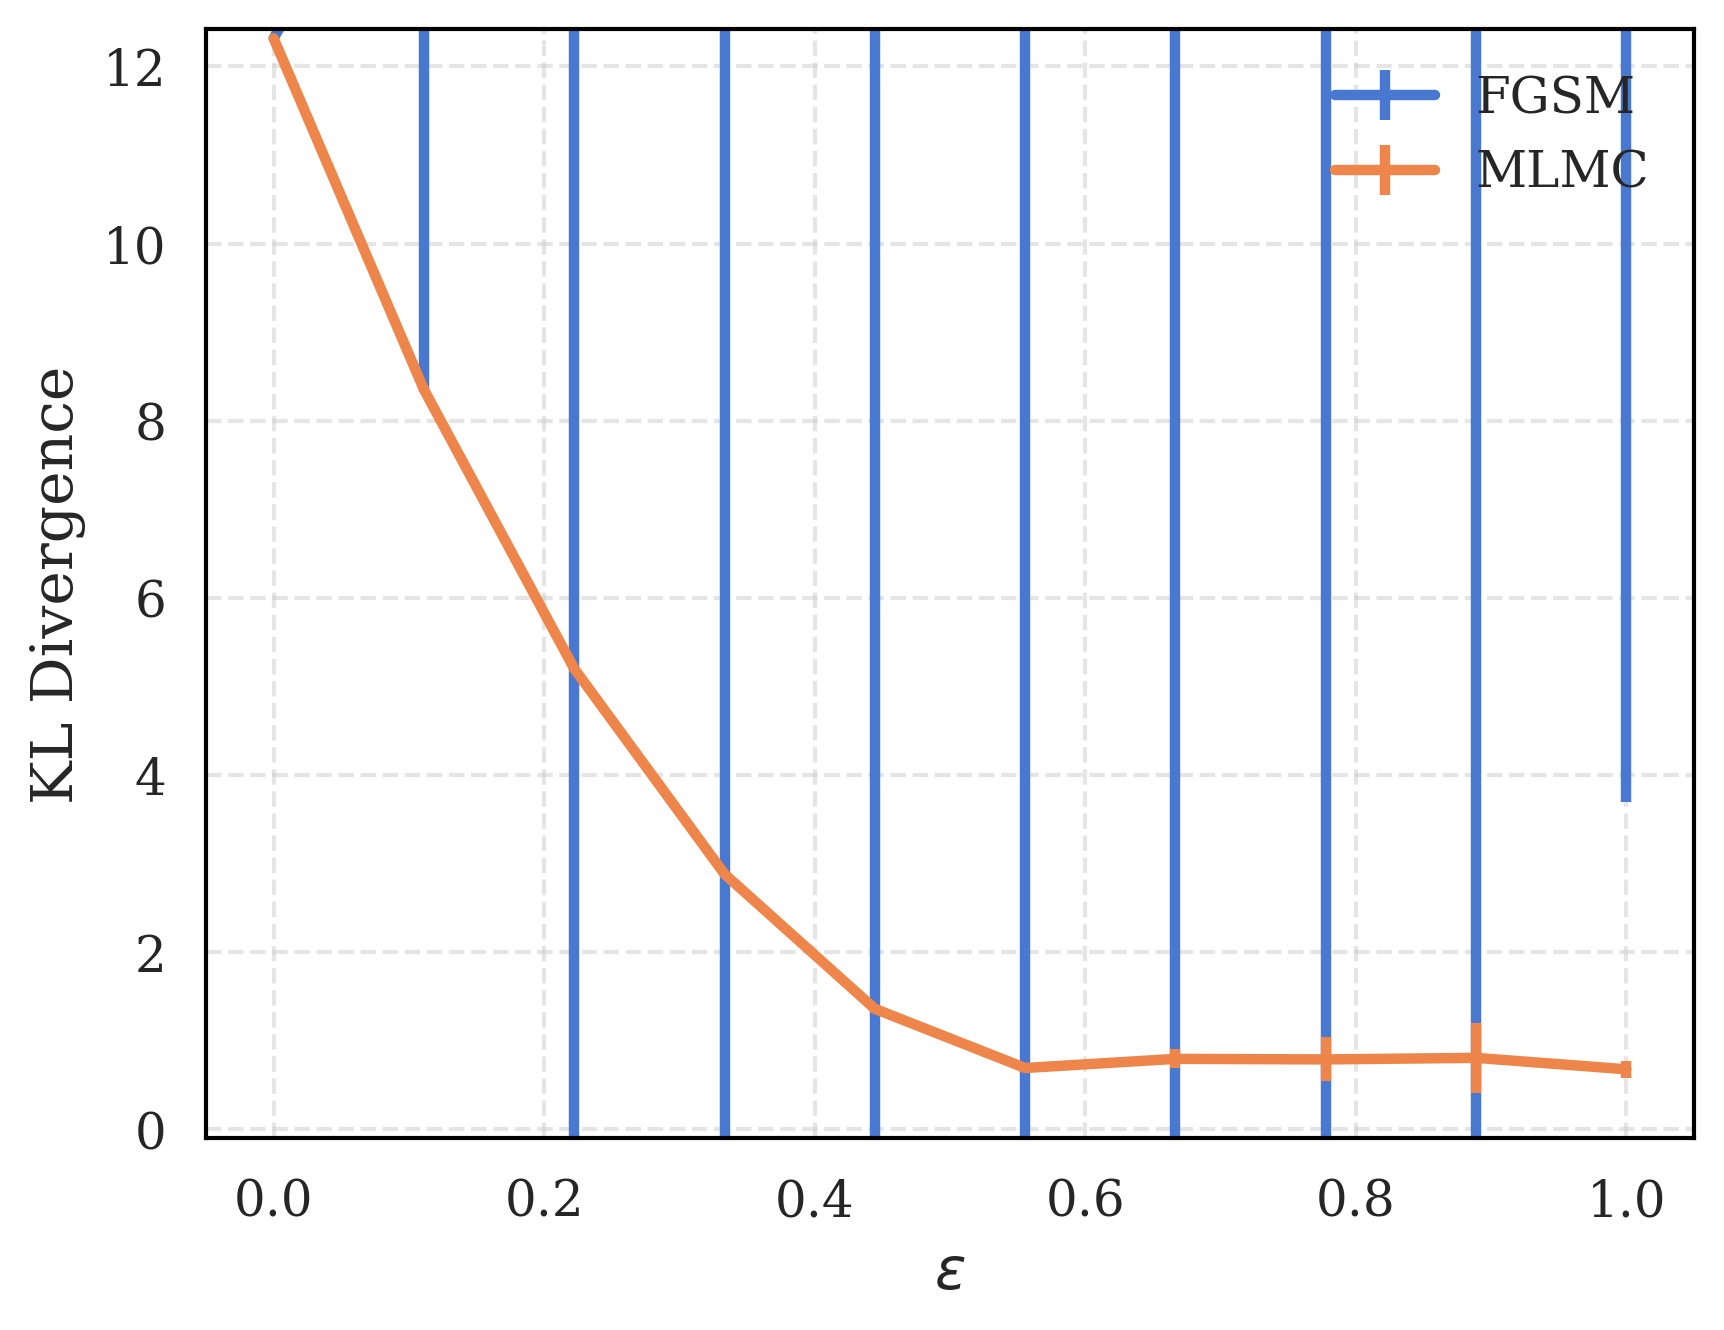

In [14]:
plt.errorbar(epsilons, np.mean(kl_fsgm, axis=0), yerr=2*np.std(kl_fsgm, axis=0), label='FGSM')
plt.errorbar(epsilons, np.mean(kl_mlmc, axis=0), yerr=2*np.std(kl_mlmc, axis=0), label='MLMC')
plt.legend()
plt.xlabel('$\epsilon$')
plt.ylabel('KL Divergence')
plt.ylim(-0.1, np.max(kl_mlmc) + 0.1)

#### appd = N(mu, 2var)

Early stopping at iteration 183


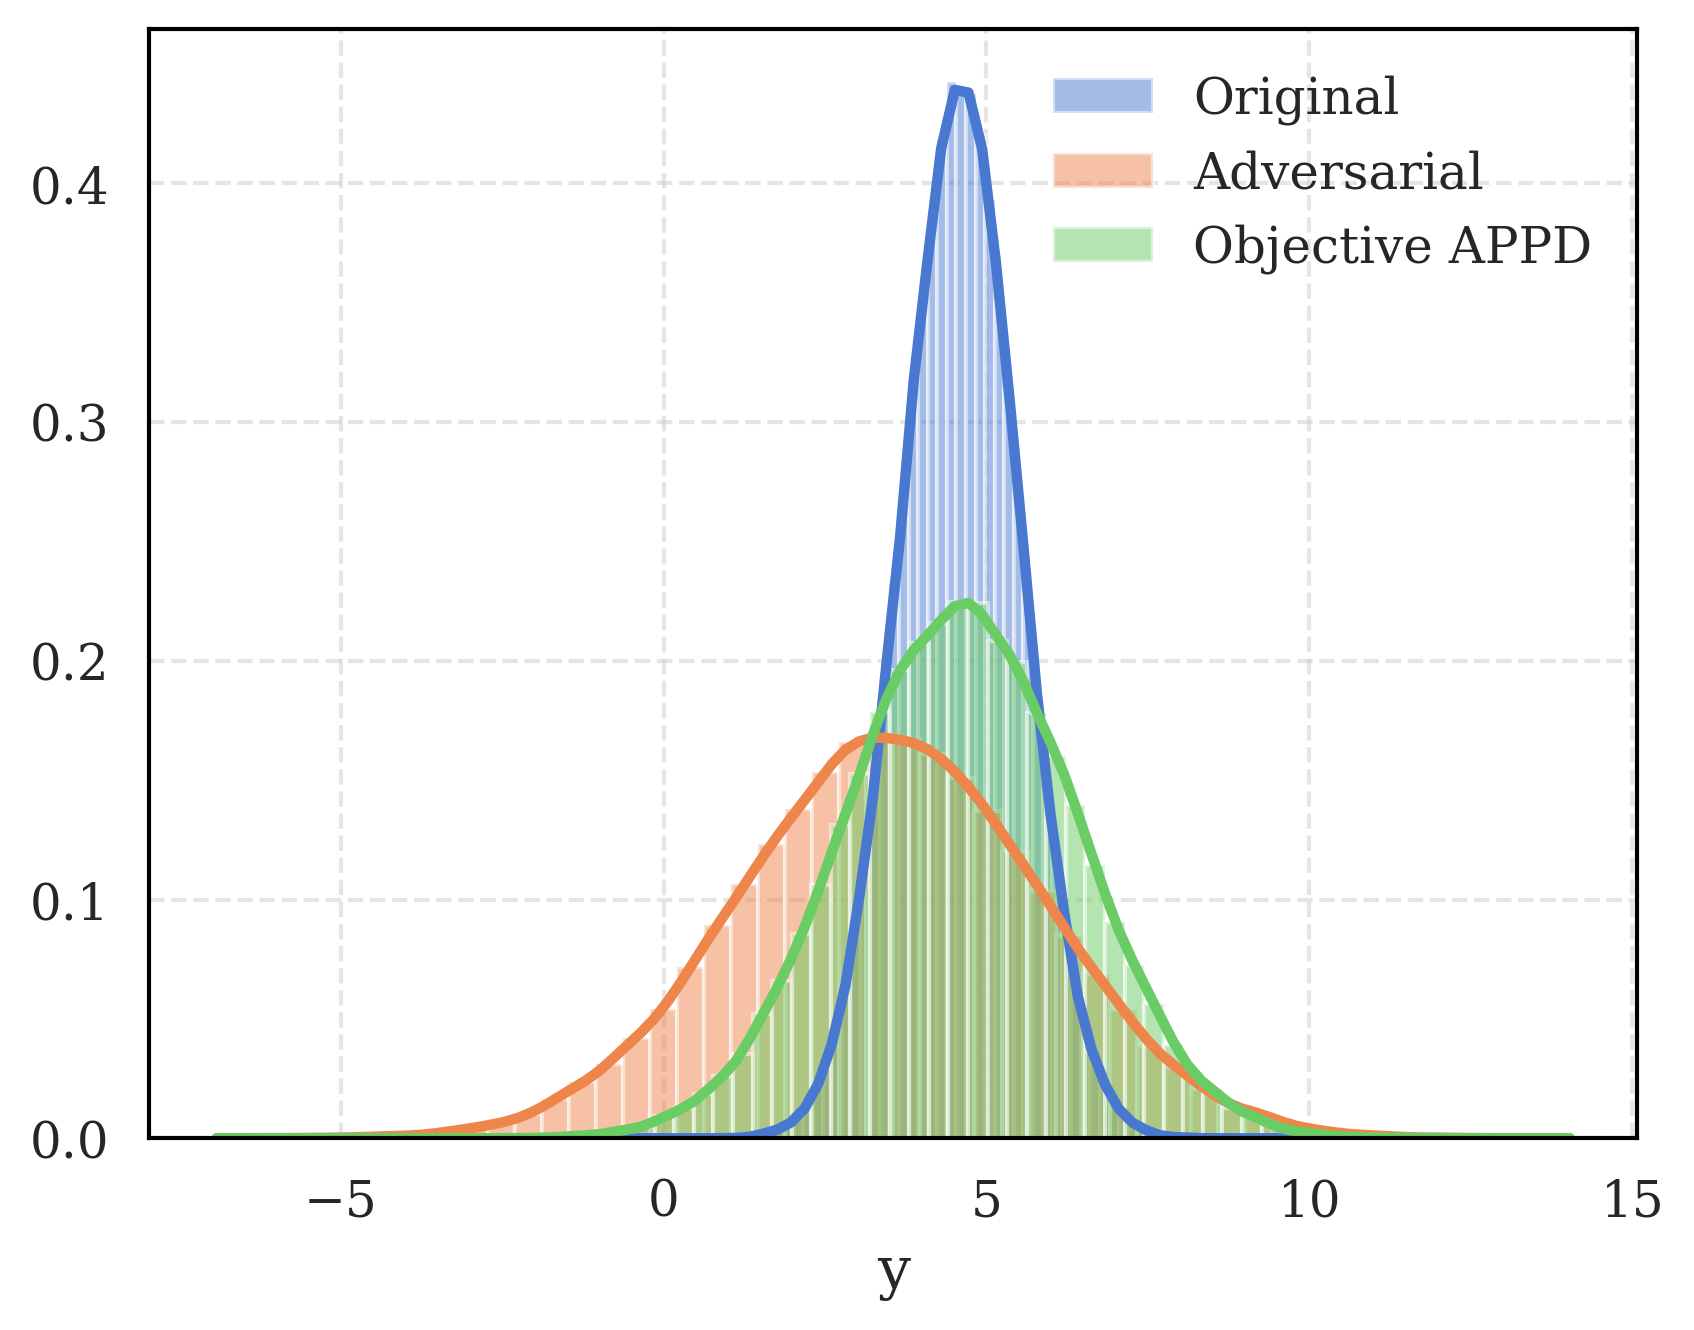

In [15]:
# Attack example
x = X_test[17,:].copy()
x = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
std = model.sample_predictive_distribution(x, 1000).std()
mu = model.sample_predictive_distribution(x, 1000).mean()
appd = torch.distributions.normal.Normal(mu, 2 * std)
x_adv_distr, x_adv_values = mlmc_attack(model, x, appd=appd, epsilon=2, R=10, lr=0.001, n_iter=1000)
plot_ppds(model, x, x_adv_distr, appd)

<>:35: SyntaxWarning: invalid escape sequence '\e'
<>:35: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipykernel_2690304/3702302221.py:35: SyntaxWarning: invalid escape sequence '\e'
  plt.xlabel('$\epsilon$')


Early stopping at iteration 12
Early stopping at iteration 14
Early stopping at iteration 28
Early stopping at iteration 12
Early stopping at iteration 182
Early stopping at iteration 12
Early stopping at iteration 12
Early stopping at iteration 130
Early stopping at iteration 12
Early stopping at iteration 12
Early stopping at iteration 41
Early stopping at iteration 12
Early stopping at iteration 23
Early stopping at iteration 220
Early stopping at iteration 12
Early stopping at iteration 12
Early stopping at iteration 49
Early stopping at iteration 253
Early stopping at iteration 12
Early stopping at iteration 12
Early stopping at iteration 24
Early stopping at iteration 185
Early stopping at iteration 20
Early stopping at iteration 24
Early stopping at iteration 12
Early stopping at iteration 74
Early stopping at iteration 12
Early stopping at iteration 15
Early stopping at iteration 73
Early stopping at iteration 293
Early stopping at iteration 12
Early stopping at iteration 12
Ea

(-0.1, 19.977161026000978)

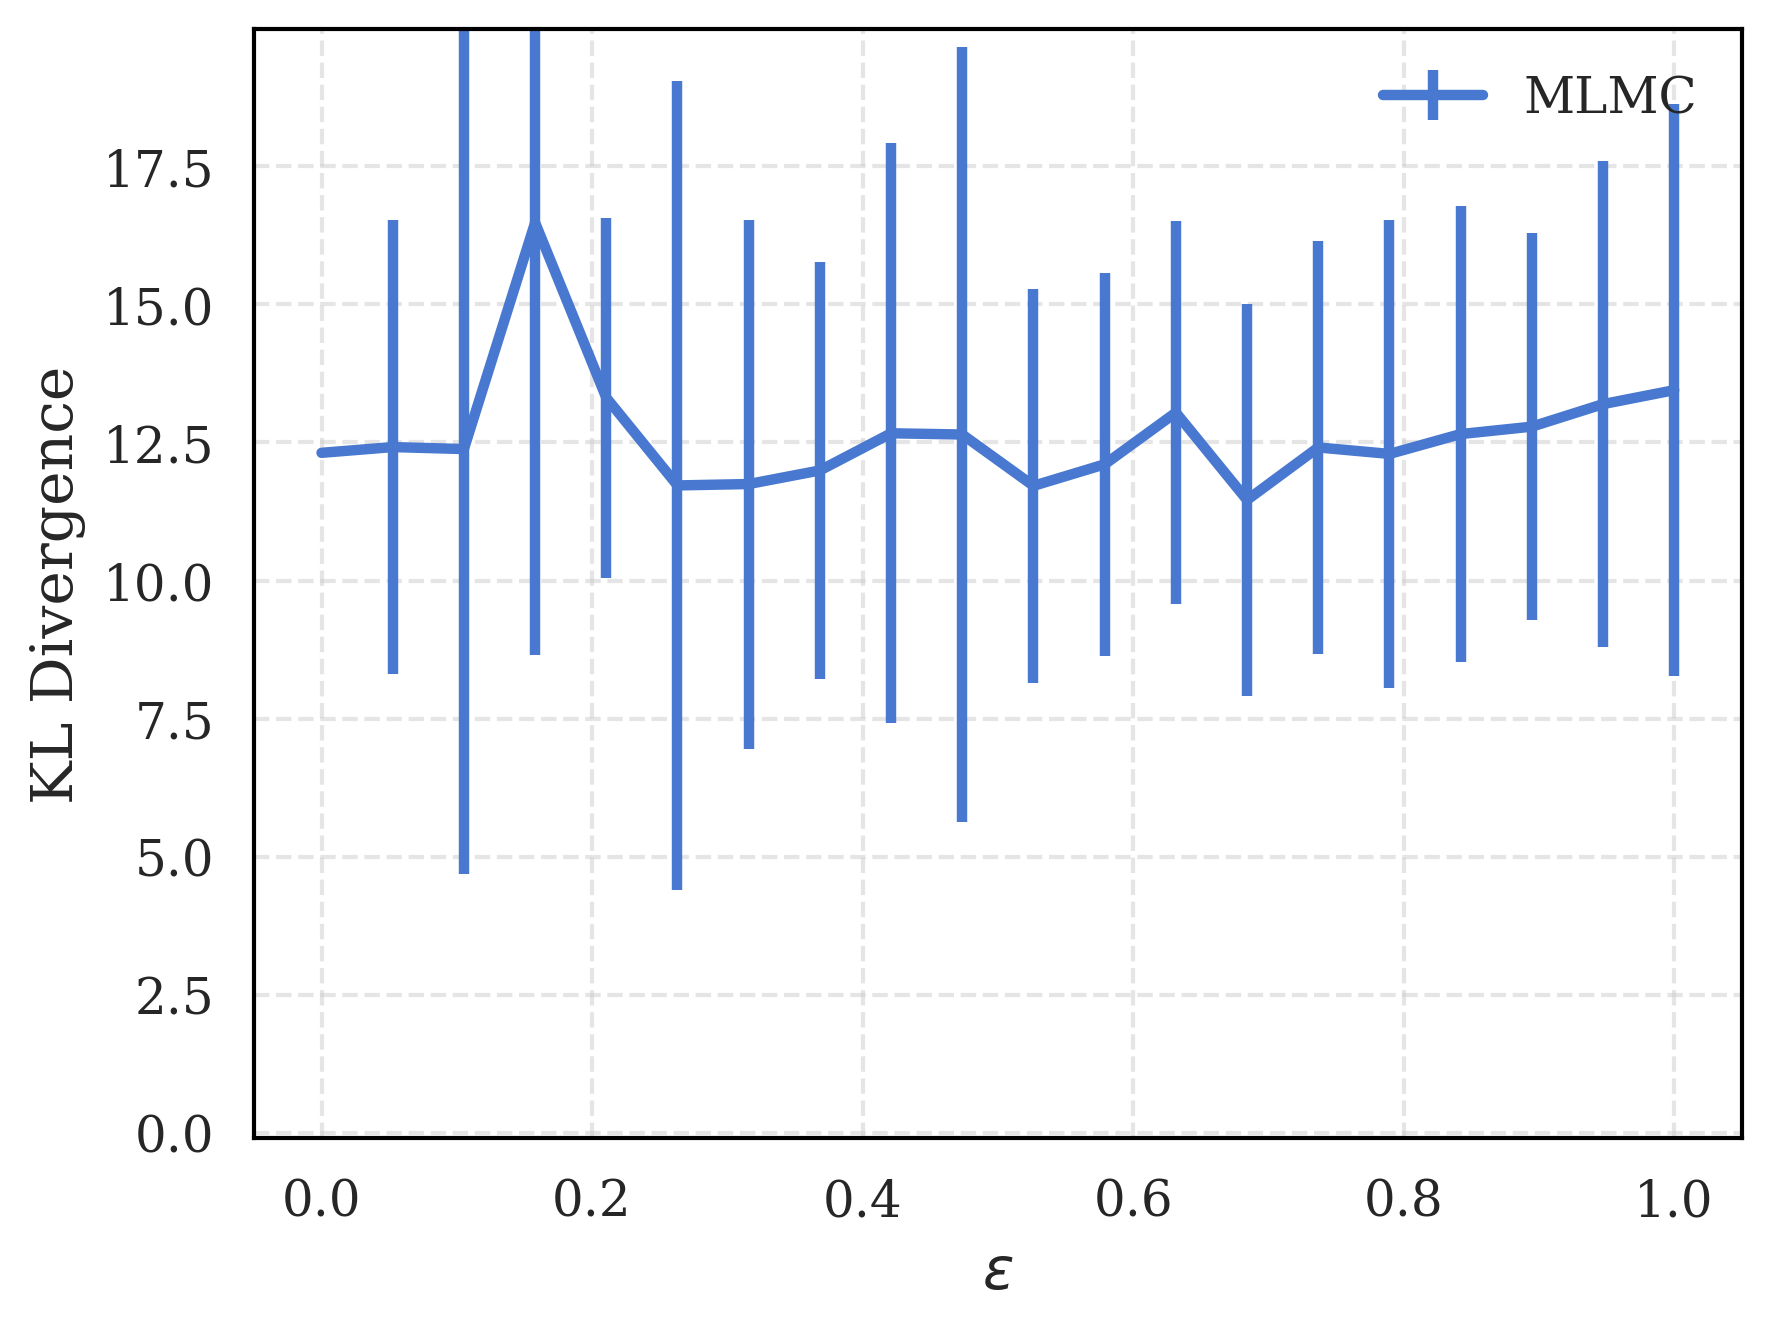

In [16]:
# plot KL divergence as a function of the strength of the attack
n_jobs = 66
x = X_test[17,:].copy()
x = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
sigma2 = model.sample_posterior_distribution(1000)['sigma2'].mean()
mu = model.sample_predictive_distribution(x, 1000).mean()
std = model.sample_predictive_distribution(x, 1000).std()
appd = torch.distributions.normal.Normal(mu, 2 * std)

# Function to calculate KL divergence for a given epsilon
def compute_kl_divergence(epsilon):
    x_adv_distr, _ = mlmc_attack(model, x, appd, epsilon=2*epsilon, R=10, lr=0.01, n_iter=300)
    mu_adv = model.sample_predictive_distribution(x_adv_distr, 1000).mean()
    sigma2_adv = model.sample_predictive_distribution(x_adv_distr, 1000).var()
    kl = kl_to_appd(mu_adv, sigma2_adv, mu, 4 * std ** 2).item()
    x_fgsm = fgsm_attack(model, x, epsilon=epsilon, R=10)
    mu_fgsm = model.sample_predictive_distribution(x_fgsm, 1000).mean()
    sigma2_fgsm = model.sample_predictive_distribution(x_fgsm, 1000).var()
    kl_fsgm = kl_to_appd(mu_fgsm, sigma2_fgsm, mu, 4 * std ** 2).item()
    return kl, kl_fsgm


# Define the range of epsilon values
epsilons = np.linspace(0, 1, 20)
kl_alls = []

for _ in range(10):
    # Use joblib to parallelize the computation of KL divergences
    kl_values = Parallel(n_jobs=n_jobs)(
        delayed(compute_kl_divergence)(epsilon) for epsilon in epsilons  
    )
    kl_alls.append(kl_values)

kl_mlmc = np.array(kl_alls)[:, :, 0]
kl_fsgm = np.array(kl_alls)[:, :, 1]
# error bars as std
plt.errorbar(epsilons, np.mean(kl_mlmc, axis=0), yerr=2*np.std(kl_mlmc, axis=0), label='MLMC')
#plt.errorbar(epsilons, np.mean(kl_fsgm, axis=0), yerr=2*np.std(kl_fsgm, axis=0), label='FGSM')
plt.legend()
plt.xlabel('$\epsilon$')
plt.ylabel('KL Divergence')
plt.ylim(-0.1, np.max(kl_mlmc) + 0.1)

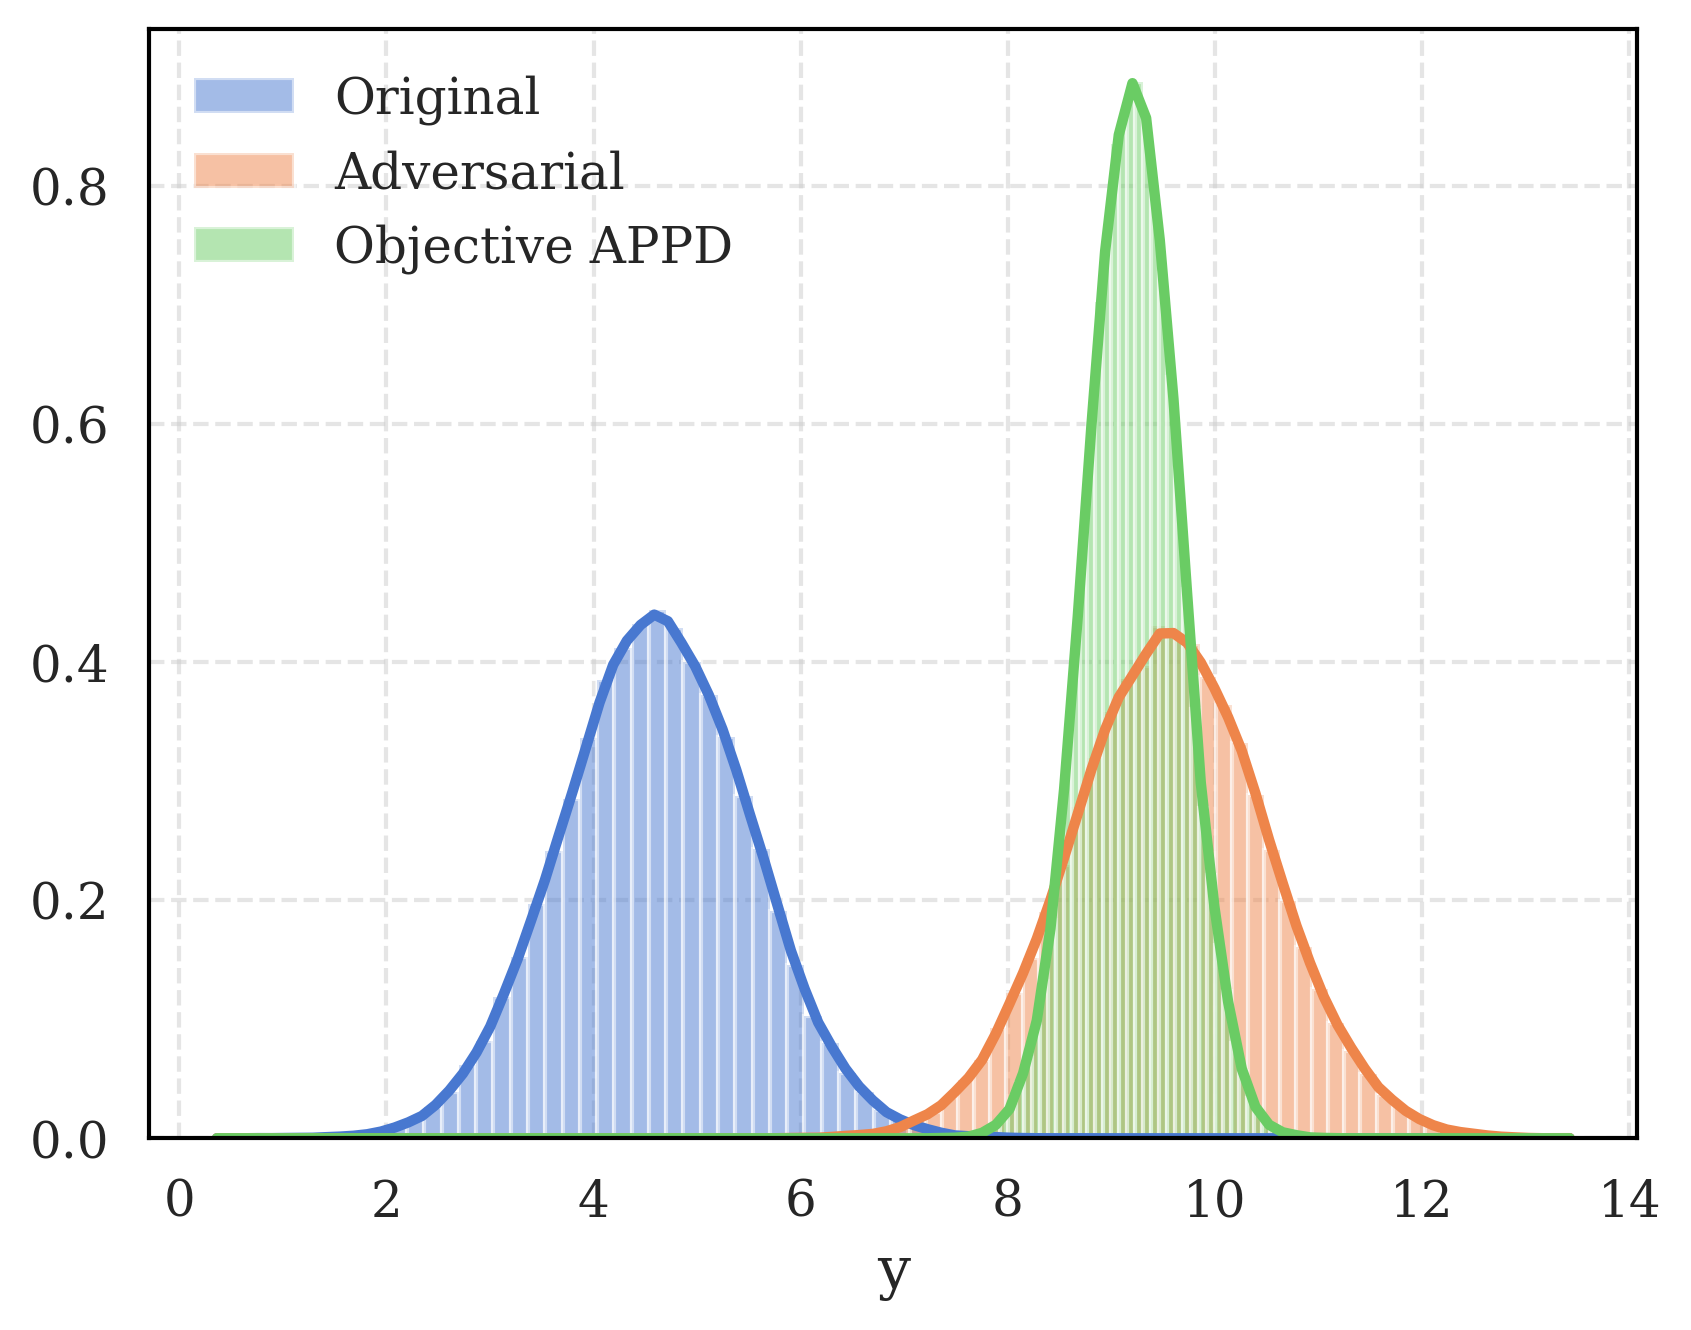

In [19]:
# Attack example
x = X_test[17,:].copy()
x = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
std = model.sample_predictive_distribution(x, 1000).std()
mu = model.sample_predictive_distribution(x, 1000).mean()
appd = torch.distributions.normal.Normal(2 * mu, 0.5 * std)
x_adv_distr, x_adv_values = mlmc_attack(model, x, appd=appd, epsilon=5, R=10, lr=0.1, n_iter=400)
plot_ppds(model, x, x_adv_distr, appd)

### Case 2b: Same model as case 1

In [20]:
# Fit the model
model = NormalKnownVariancePriorLinearRegression(prior_params={
    'mu': torch.zeros(X_train.shape[1]), 
    'lam': torch.eye(X_train.shape[1]), 
    'sigma2': torch.tensor([1])},)
data = {'X': torch.tensor(X_train, dtype=torch.float32), 'y': torch.tensor(y_train, dtype=torch.float32)}
model.fit(data)

Early stopping at iteration 162


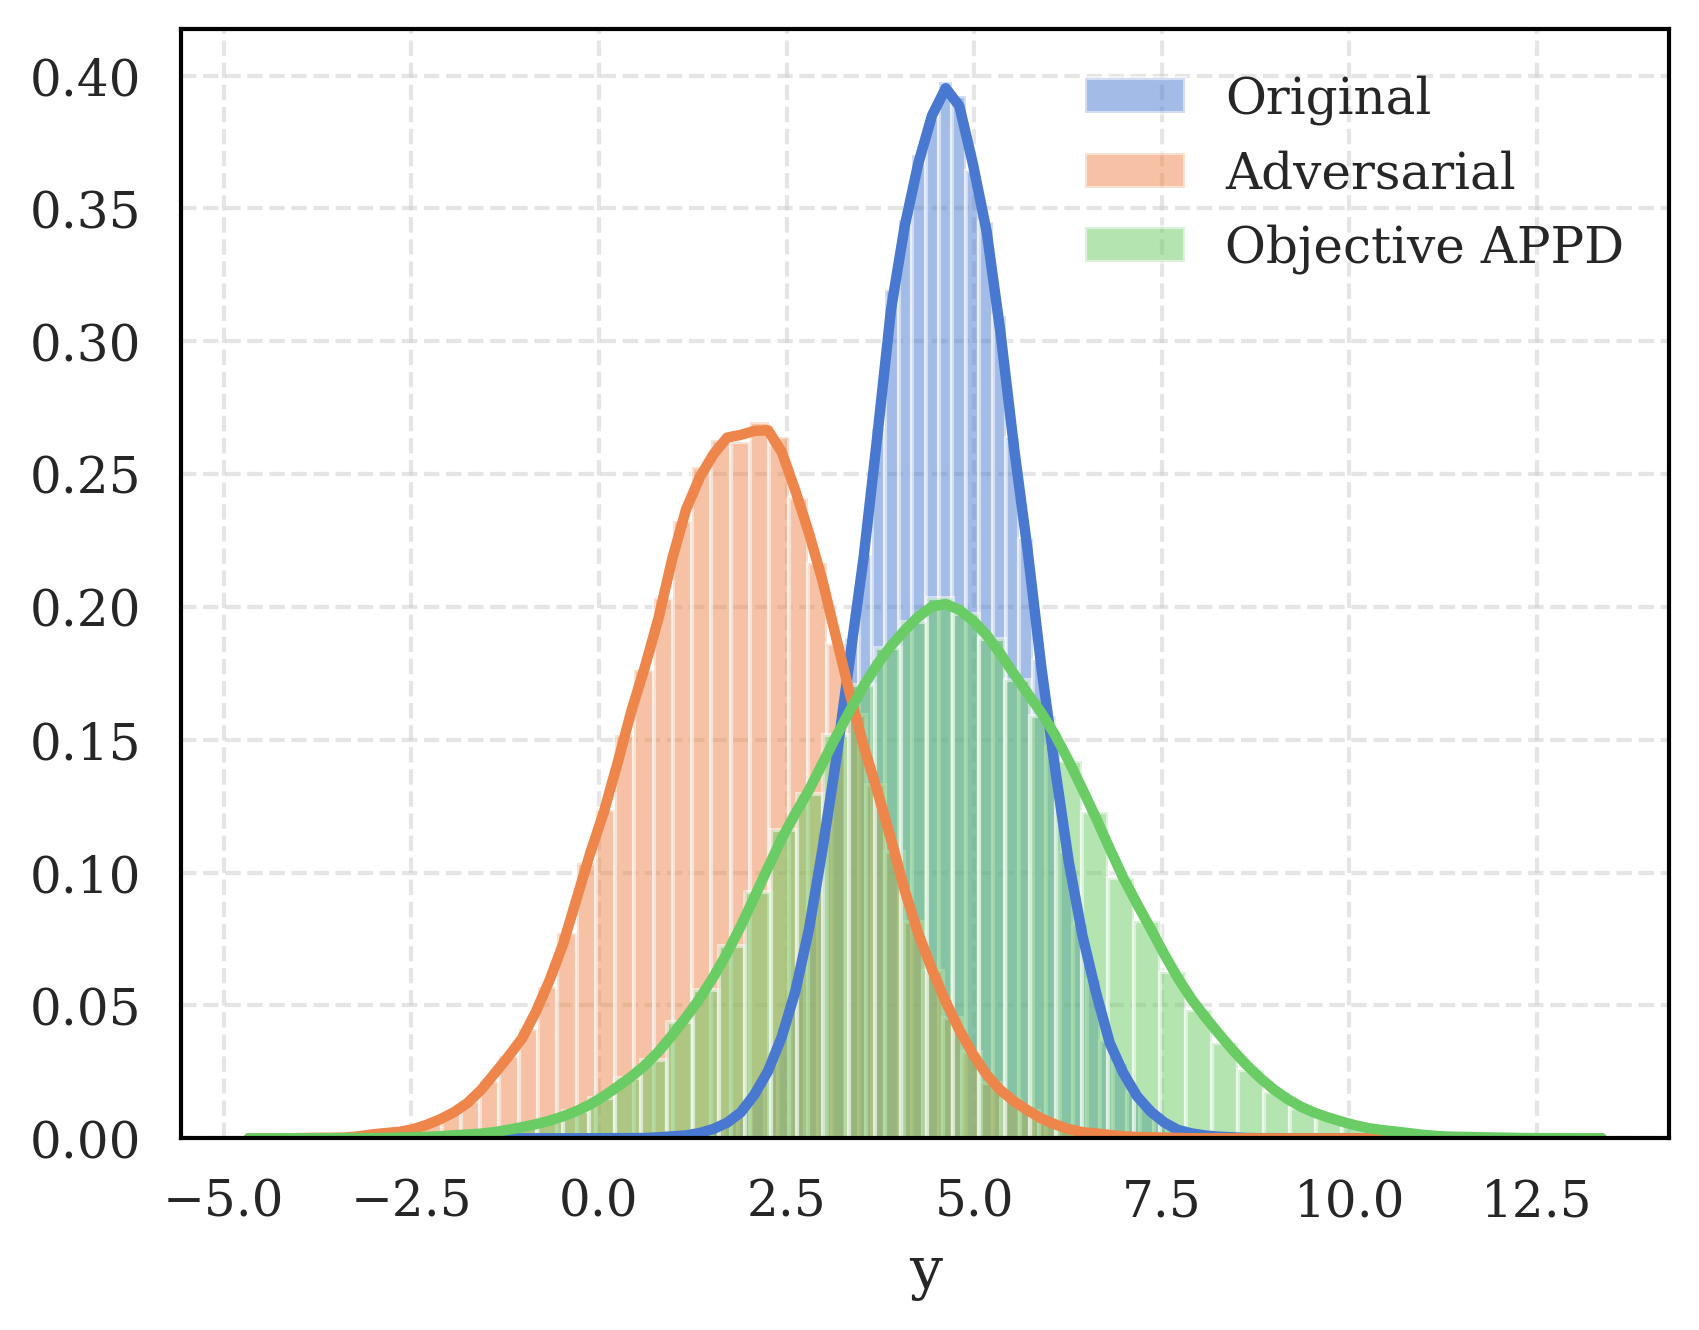

In [21]:
# Attack example
x = X_test[17,:].copy()
x = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
std = model.sample_predictive_distribution(x, 1000).std()
appd = torch.distributions.normal.Normal(x.T @ model.mu, 2 * std)
x_adv_distr, x_adv_values = mlmc_attack(model, x, appd=appd, epsilon=2, lr=.1, R=10, n_iter=400)
plot_ppds(model, x, x_adv_distr, appd)

Early stopping at iteration 193


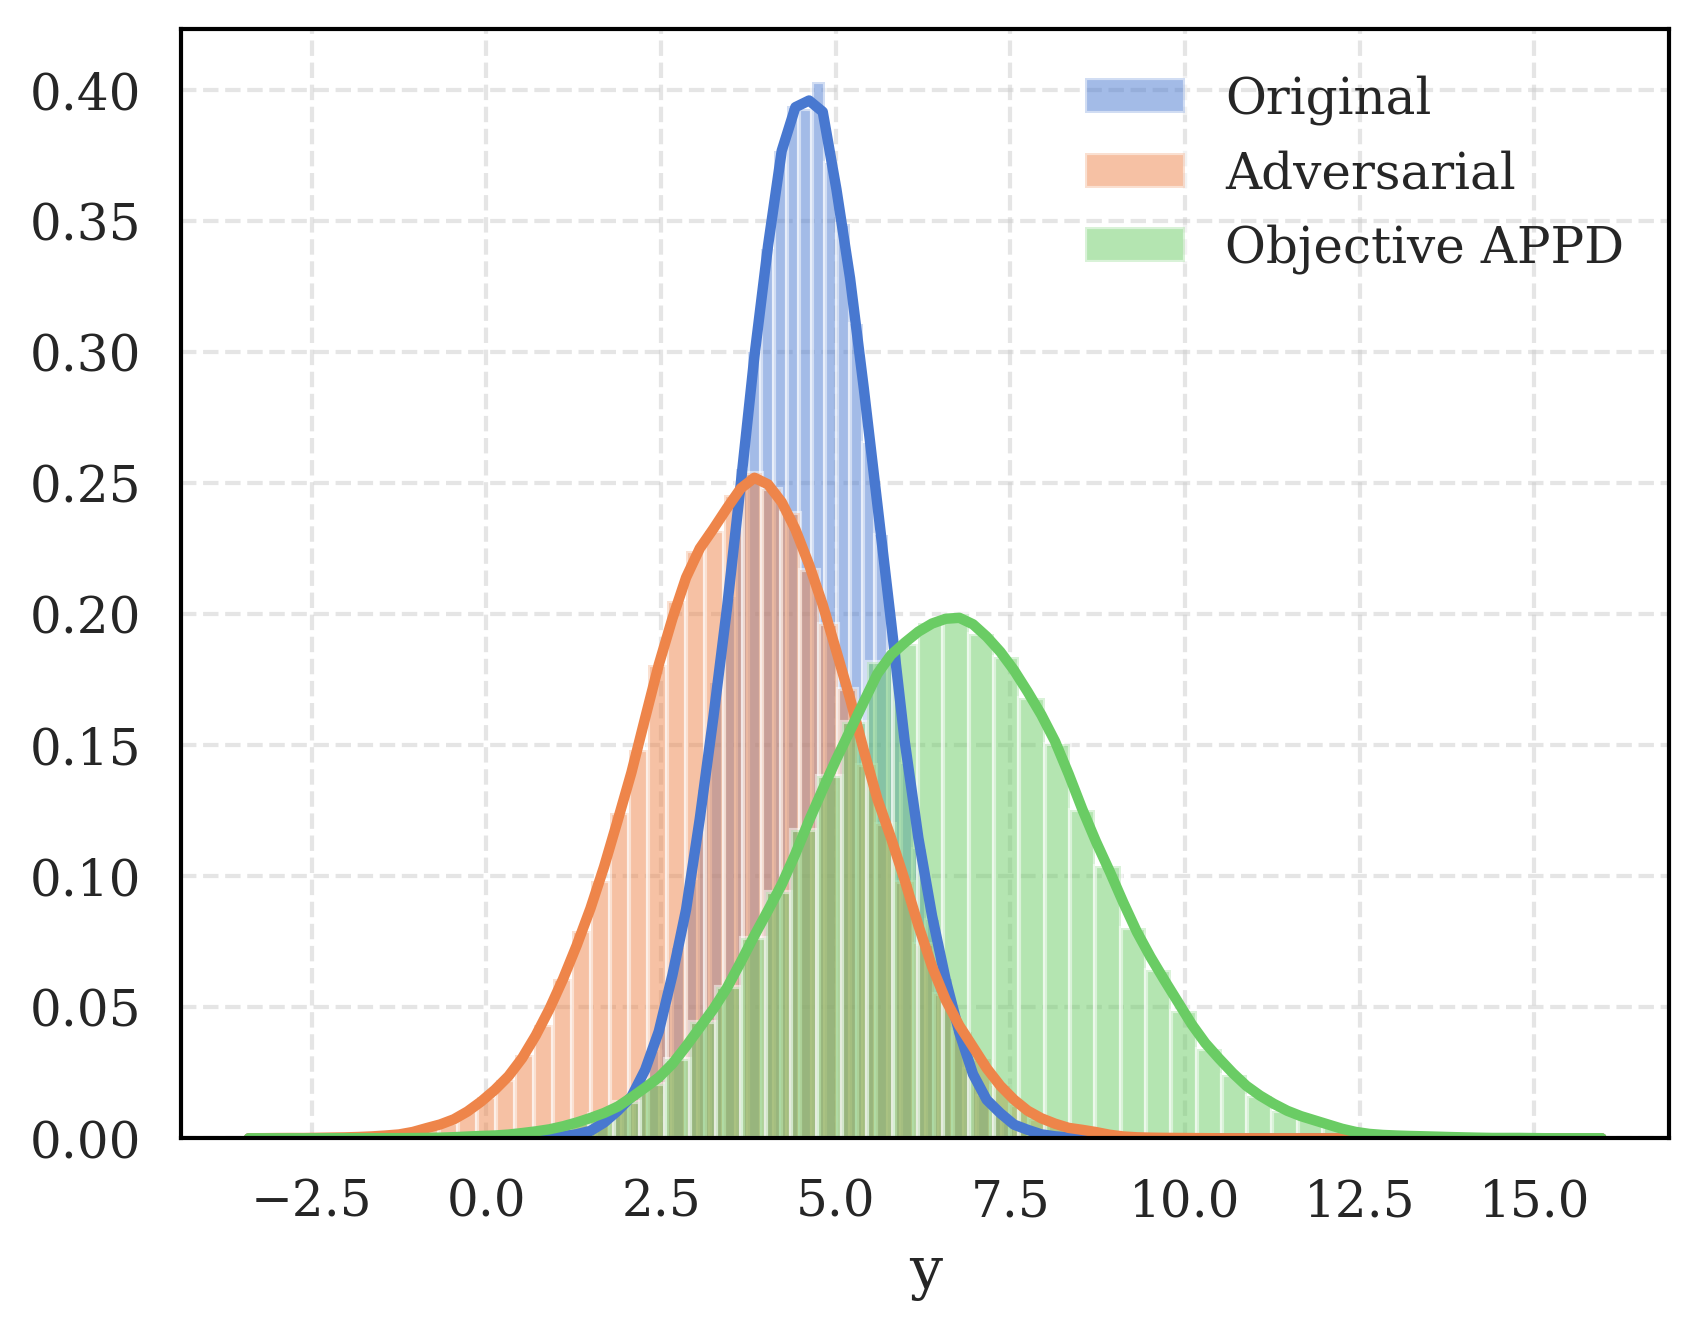

In [22]:
# Attack example
x = X_test[17,:].copy()
x = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
std = model.sample_predictive_distribution(x, 1000).std()
appd = torch.distributions.normal.Normal(2 + x.T @ model.mu, 2 * std)
x_adv_distr, x_adv_values = mlmc_attack(model, x, appd=appd, epsilon=2, lr=.1, R=10, n_iter=400)
plot_ppds(model, x, x_adv_distr, appd)

## Maximum disruption problem

In [23]:
# Normal Inverse Gamma Model
model = NormalInverseGammaPriorLinearRegression(prior_params={
    'mu': torch.zeros(X_train.shape[1]), 
    'lam': torch.eye(X_train.shape[1]), 
    'a': torch.tensor([10]), 
    'b': torch.tensor([1])},)
data = {'X': torch.tensor(X_train, dtype=torch.float32), 'y': torch.tensor(y_train, dtype=torch.float32)}
model.fit(data)

Early stopping at iteration 19


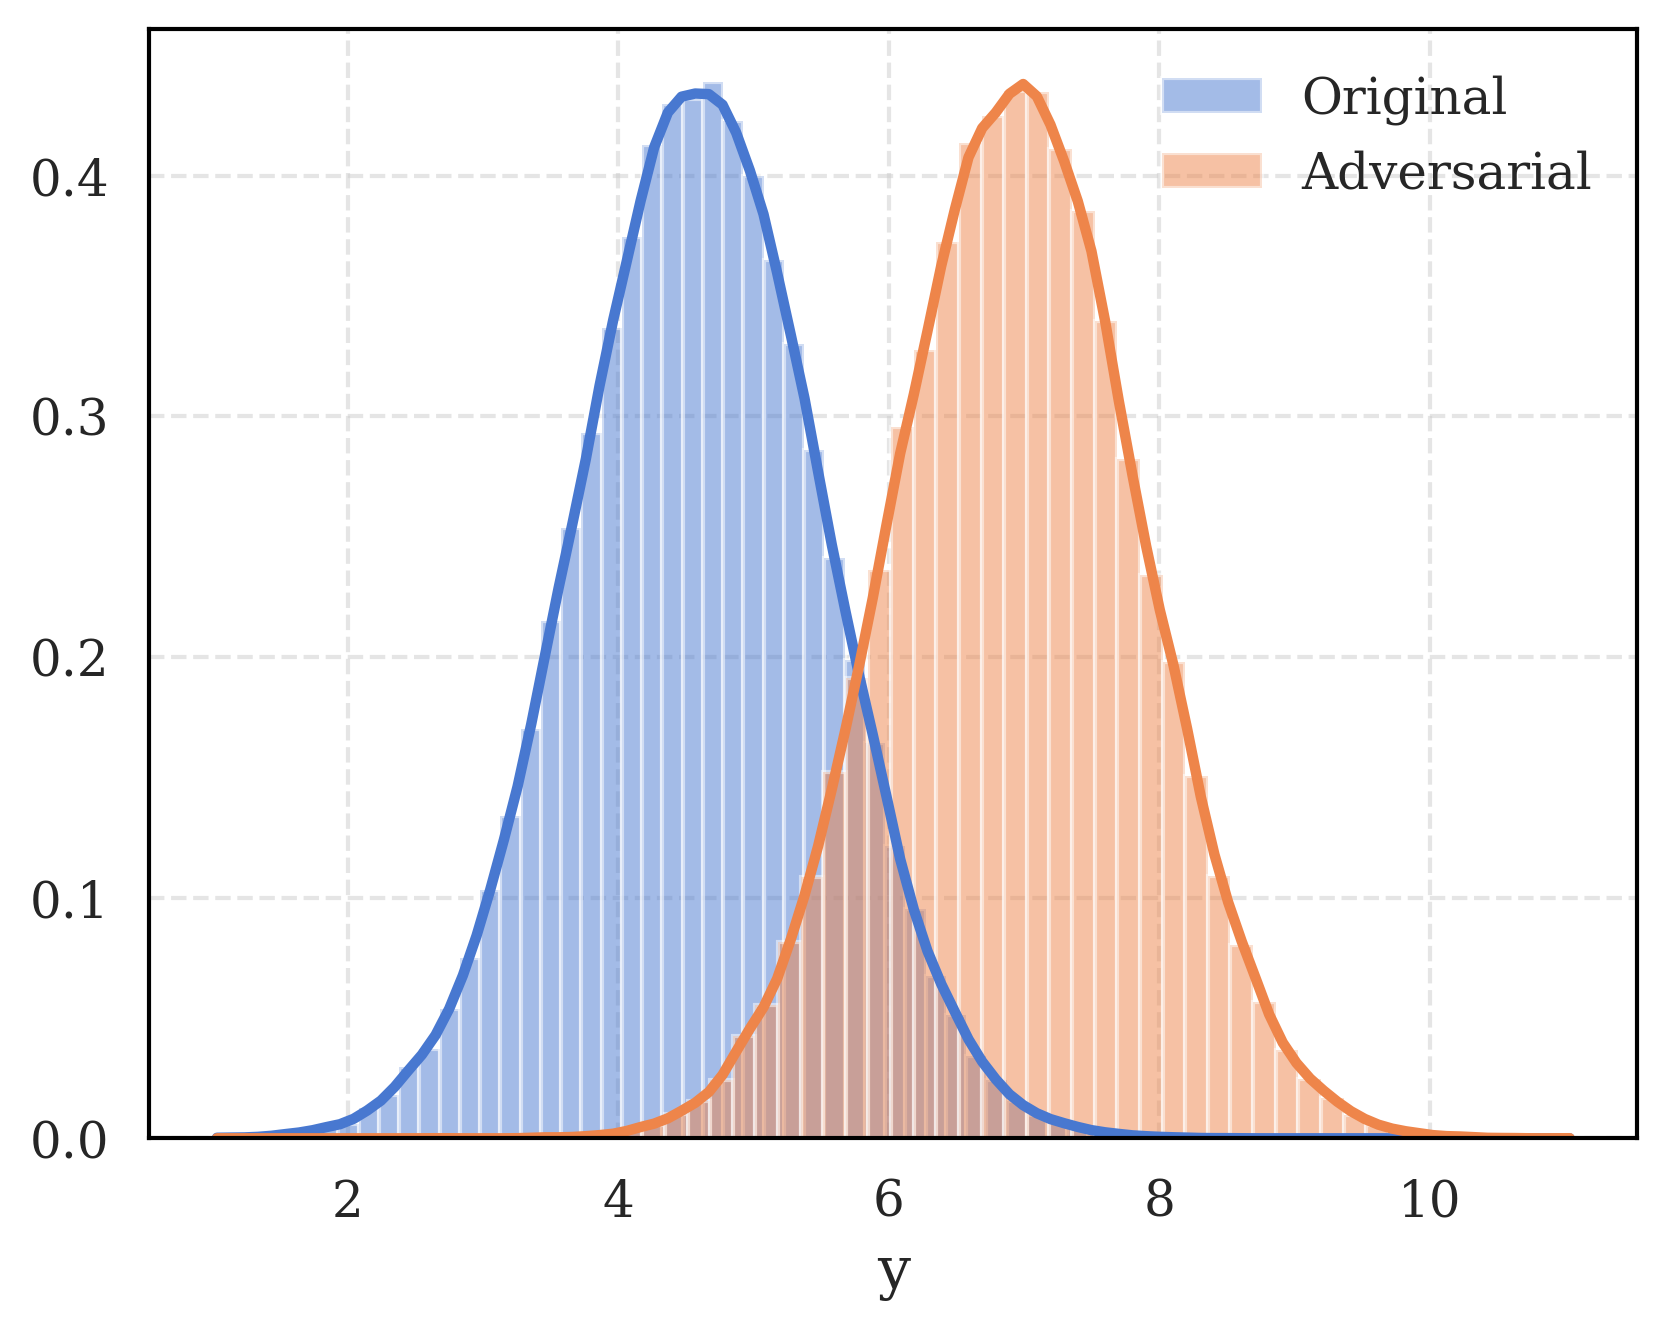

In [24]:
# Attack example
x = X_test[17,:].copy()
x = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
x_adv_distr, x_adv_values = mlmc_attack(model, x, epsilon=.3, R=100, lr=0.01, n_iter=200)
plot_ppds(model, x, x_adv_distr)

<>:26: SyntaxWarning: invalid escape sequence '\e'
<>:26: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipykernel_2690304/737261988.py:26: SyntaxWarning: invalid escape sequence '\e'
  ax.set_title(f'$\epsilon=${epsilon:.2f}')


Early stopping at iteration 27
Early stopping at iteration 16
Early stopping at iteration 20
Early stopping at iteration 30


Early stopping at iteration 31
Early stopping at iteration 33
Early stopping at iteration 34
Early stopping at iteration 39
Early stopping at iteration 38
Early stopping at iteration 51


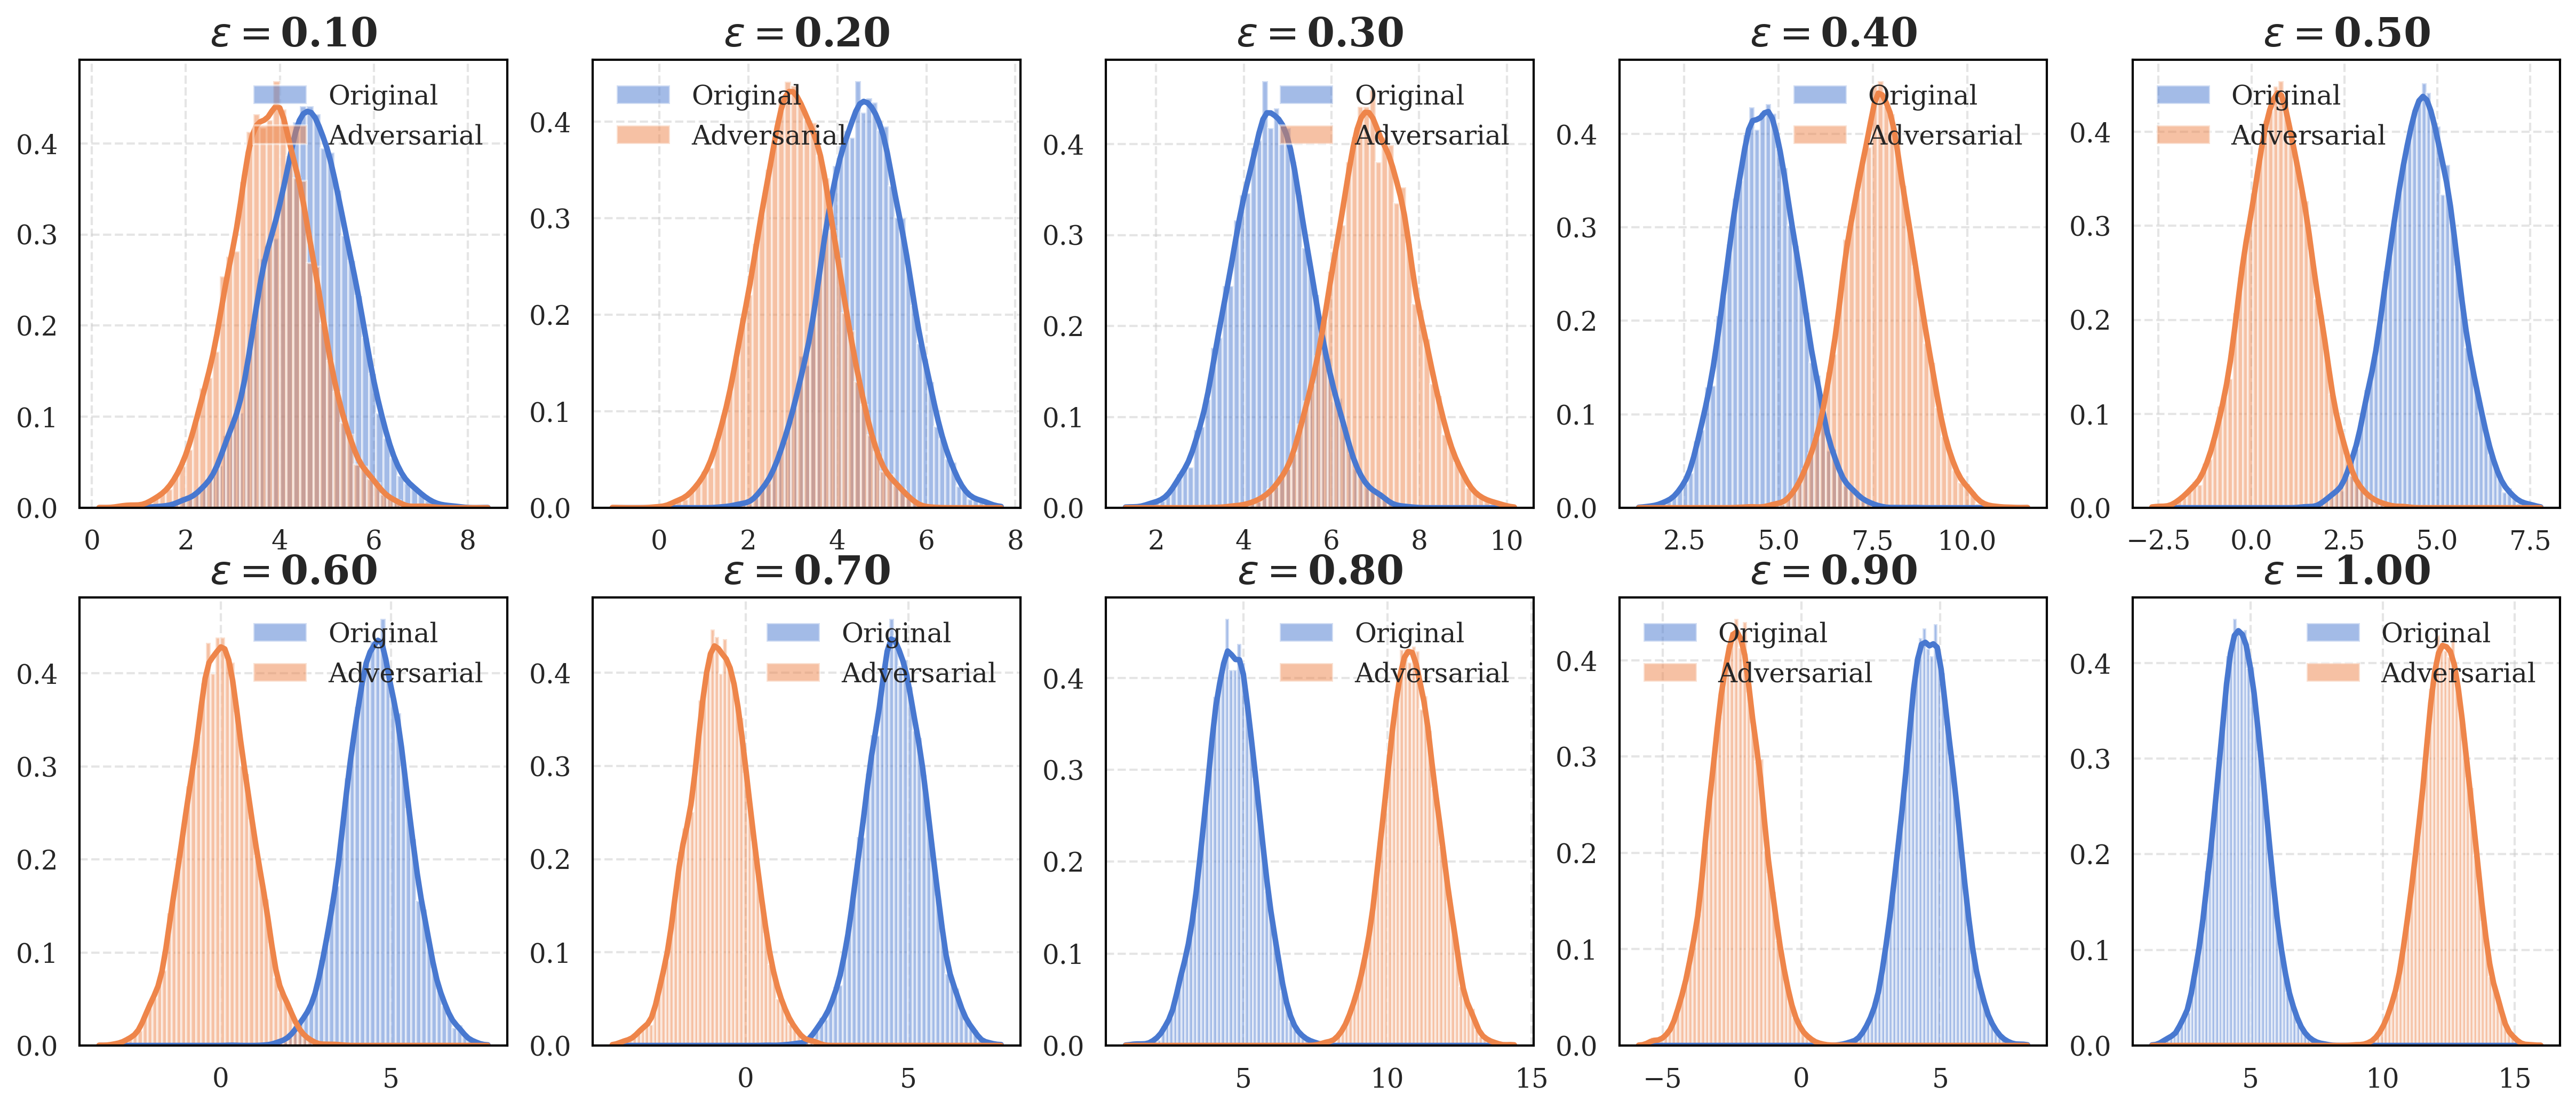

In [25]:
# Plot the histogram for 10 different epsilon values as subplots
epsilons = np.linspace(0.1, 1, 10)
fig, axs = plt.subplots(2, 5, figsize=(20, 8))
for i, epsilon in enumerate(epsilons):
    x_adv_distr, _ = mlmc_attack(model, x, epsilon=epsilon)
    ax = axs[i // 5, i % 5]

    y_samples = model.sample_predictive_distribution(x, num_samples=10000).numpy()
    y_adv_samples = model.sample_predictive_distribution(x_adv_distr, num_samples=10000).numpy()

    kde = gaussian_kde(y_samples.T)
    kde_adv = gaussian_kde(y_adv_samples.T)

    ax.hist(y_samples, bins=50, alpha=0.5, label='Original', density=True)
    ax.hist(y_adv_samples, bins=50, alpha=0.5, label='Adversarial', density=True)

    ys = np.linspace(
        min(np.min(y_samples), np.min(y_adv_samples)), 
        max(np.max(y_samples), np.max(y_adv_samples)), 
        100)
    # plot with same color and label
    ax.plot(ys, kde(ys), color='C0')
    ax.plot(ys, kde_adv(ys), color='C1')
    ax.legend()

    ax.set_title(f'$\epsilon=${epsilon:.2f}')

### Known variance model

In [26]:
model = NormalKnownVariancePriorLinearRegression(prior_params={
    'mu': torch.zeros(X_train.shape[1]), 
    'lam': torch.eye(X_train.shape[1]), 
    'sigma2': torch.tensor([1])},)
data = {'X': torch.tensor(X_train, dtype=torch.float32), 'y': torch.tensor(y_train, dtype=torch.float32)}
model.fit(data)

In [27]:
x = X_test[17,:].copy()
x = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
lr = 0.0
mu_n = model.mu
lam_n = model.lam
sigma2 = model.sigma2
x_adv = (x + torch.randn_like(x) * 0.01).clone().detach().requires_grad_(True)  # add some noise to the input so kl is not zero
optimizer = SGD([x_adv], lr=0.0)
x_adv.requires_grad = True
optimizer.zero_grad()

kl = - kl_div(mu_n, lam_n, sigma2, x, x_adv)  # maximum disruption problem
kl.backward()
real_grad = x_adv.grad.clone().detach()

(array([135., 113., 111., 112., 112.,  84.,  83.,  57.,  51.,  41.,  34.,
         24.,  13.,  13.,   6.,   3.,   5.,   1.,   1.,   1.]),
 array([1.55859729e-02, 1.55973980e+00, 3.10389363e+00, 4.64804746e+00,
        6.19220129e+00, 7.73635512e+00, 9.28050895e+00, 1.08246628e+01,
        1.23688166e+01, 1.39129704e+01, 1.54571243e+01, 1.70012781e+01,
        1.85454319e+01, 2.00895858e+01, 2.16337396e+01, 2.31778934e+01,
        2.47220472e+01, 2.62662011e+01, 2.78103549e+01, 2.93545087e+01,
        3.08986626e+01]),
 <BarContainer object of 20 artists>)

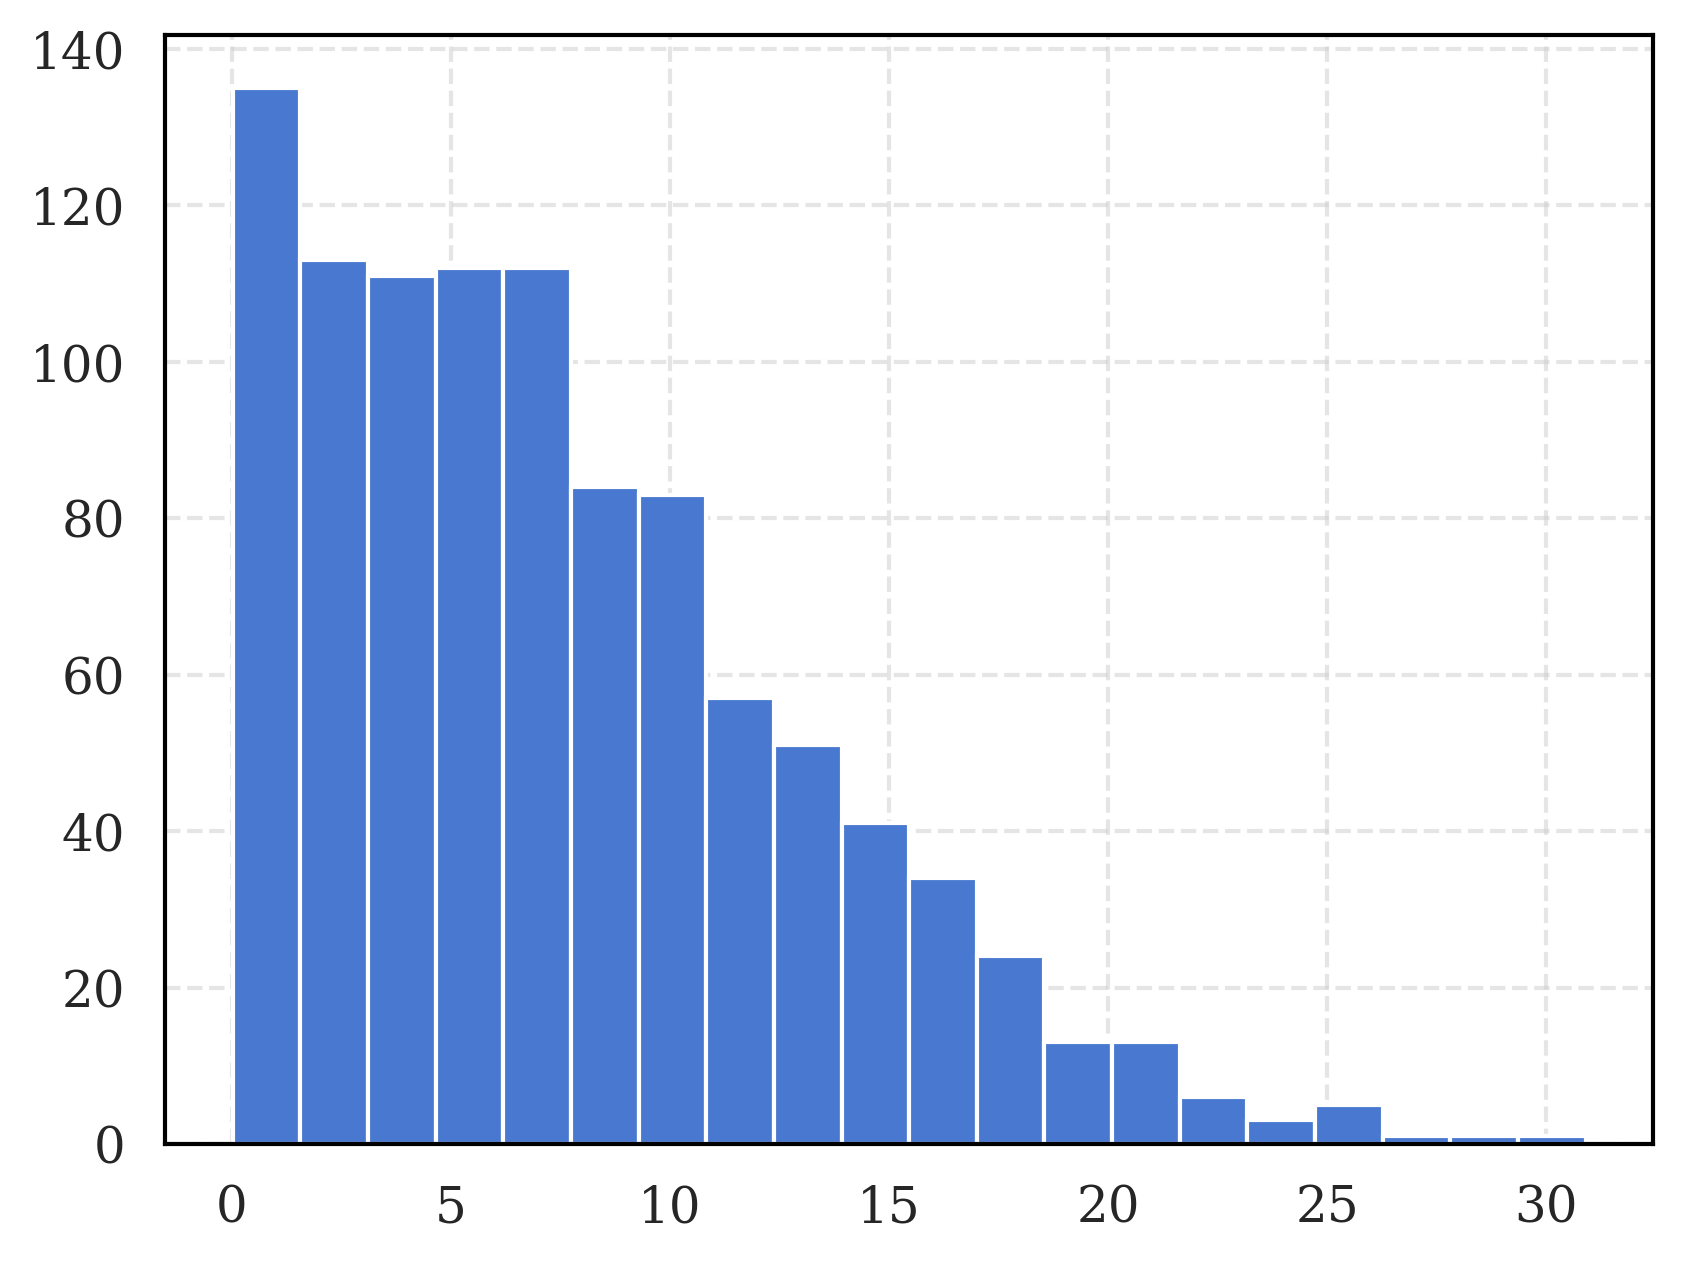

In [28]:
norms = []
for it in range(1000):
    y = model.sample_predictive_distribution(x, num_samples=1)
    gradient_estimate = mlmc_gradient_estimator(y, x_adv, 100, model, M0=2, tau=1)
    norms.append(torch.norm(real_grad - gradient_estimate).detach().item())
        
plt.hist(norms, bins=20)

In [29]:
# same as before but estimate the gradient doing the mean of 1000 iterations and doing it in paralell with joblib
def compute_norms(it):
    y = model.sample_predictive_distribution(x, num_samples=1)
    gradient_estimate = mlmc_gradient_estimator(y, x_adv, 100, model, M0=2, tau=1).clone().detach()
    for _ in range(100):
        y = model.sample_predictive_distribution(x, num_samples=1)
        gradient_estimate = mlmc_gradient_estimator(y, x_adv, 100, model, M0=2, tau=1).clone().detach()
        gradient_estimate += gradient_estimate
    gradient_estimate /= 101
    return torch.norm(real_grad - gradient_estimate).detach().item()

n_jobs = 66
norms = Parallel(n_jobs=n_jobs)(delayed(compute_norms)(i) for i in range(1000))
plt.hist(norms, bins=20)

# Comparison of 3 datasets: Wine, energy and housing

In [4]:
# Load the dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx"
data = pd.read_excel(url)

# The last two columns are the target variables (Heating Load and Cooling Load)
X = data.iloc[:, :-2].values  # Covariates
y = data.iloc[:, -2].values  # Heating Load
y_energy = y / 4  # to make the target variable similar to the other datasets

# Normalize the data
scaler = MinMaxScaler()
X_energy = scaler.fit_transform(X)

In [5]:
# Wine Quality dataset with response in {3, 4, 5, 6, 7, 8}, 11 features and 4898 samples

# URL to the Wine Quality dataset (for example, from UCI Machine Learning Repository)
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv"
# Load the dataset directly into a Pandas DataFrame
data = pd.read_csv(url, delimiter=";")

X = data.iloc[:, :-1].values
y_wine = data.iloc[:, -1].values

# Normalize the data
scaler = MinMaxScaler()
X_wine = scaler.fit_transform(X)

In [6]:
# Housing dataset
california_housing = fetch_california_housing(as_frame=True)

X = california_housing.data.values
y_housing = california_housing.target.values

X_housing = MinMaxScaler().fit_transform(X)

In [ ]:
# For all 3 datasets: Fit the model, compute the average rmse over the test set for the original data and the adversarial examples with epsilon = 0.2 and epsilon = 0.5
datasets = ['energy', 'housing', 'wine']
epsilons = [0, 0.2, 0.5]

results = []
results_attack = []

for dataset in datasets:
    print(f'Running dataset {dataset}')
    if dataset == 'energy':
        X, y = X_energy, y_energy
    elif dataset == 'wine':
        X, y = X_wine, y_wine
    elif dataset == 'housing':
        X, y = X_housing, y_housing

    results_dataset = []
    results_dataset_attack = []
    for i in range(10):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i)

        model = NormalInverseGammaPriorLinearRegression(prior_params={
            'mu': torch.zeros(X_train.shape[1]), 
            'lam': torch.eye(X_train.shape[1]), 
            'a': torch.tensor([10]), 
            'b': torch.tensor([1])}
            )
        data = {'X': torch.tensor(X_train, dtype=torch.float32), 'y': torch.tensor(y_train, dtype=torch.float32)}
        model.fit(data)

        X_test = X_test[:88, :]  # 88 is the njobs number, so we can parallelize the computation efficiently
        y_test = y_test[:88]

        res_it = []
        res_it_attack = []
        for epsilon in epsilons:
            def compute_kl(i):
                x = torch.tensor(X_test[i,:].copy(), dtype=torch.float32).unsqueeze(1)
                std = model.sample_predictive_distribution(x, 1000).std()
                appd = torch.distributions.normal.Normal(2 + x.T @ model.mu, 2 * std)
                if epsilon == 0:
                    x_adv = x.clone().detach()
                else:
                    x_adv, _ = mlmc_attack(model, x, appd, epsilon=epsilon, verbose=False, R=10, lr=0.01, n_iter=800)
                sigma2 = model.sample_posterior_distribution(1000)[1].mean()
                att_kl = kl_to_appd(model.mu, model.lam, sigma2, x_adv, 2 * x.T @ model.mu, 4 * std ** 2).item()
                df_kl = kl_div(model.mu, model.lam, sigma2, x, x_adv).item()
                return att_kl#, df_kl

            kl_values = Parallel(n_jobs=-1)(delayed(compute_kl)(i) for i in range(X_test.shape[0]))
            #kl_values_attack = np.array(kl_values)[]
            kl = sum(kl_values)
            res_it.append(kl / X_test.shape[0])
        results_dataset.append(res_it)
    results.append(results_dataset)

Running dataset energy


Running dataset housing


In [8]:
# Display as a table
results_array = np.array(results).mean(axis=1)
results_array = np.round(results_array, 3)
results_df = pd.DataFrame(results_array, columns=epsilons, index=datasets)
results_df

,0.0,0.2,0.5
energy,31.509,25.660,16.414
housing,4.002,1.442,4.428
wine,20.025,14.010,3.810


In [9]:
# Display as a table
results_array = 2 * np.array(results).std(axis=1)
results_array = np.round(results_array, 3)
results_df = pd.DataFrame(results_array, columns=epsilons, index=datasets)
results_df

,0.0,0.2,0.5
energy,5.791,4.787,3.286
housing,0.604,0.516,0.958
wine,1.333,1.580,0.929
